**Problem**: 

Approximating the non-linear data space that makes up a PyPSA simulation. Specifically, approximating a modified IEEE 13 bus topology with a uniform (grid) input. The approximation is time sensitive.

**Objective**:

This notebook will only look at [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (RF) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will also be calculated for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, a linear regression model outperformed a non-linear model (artificial neural network) when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

* 1e5 samples (mean R2: 0.85, std dev: 0.0005)
* 1e4 samples (mean R2: 0.81, std dev: 0.005)

Running a randomized grid search with 1e5 samples produced the following results:

1. n_estimators: 99, max_depth: 73, mean training time: 226s (mean R2: 0.85 std dev: 0.0006)
2. n_estimators: 89, max_depth: 62, mean training time: 208s (mean R2: 0.85 std dev: 0.0006)
3. .
4. .


18. n_estimators: 24, max_depth: 68, mean training time: 54s (mean R2: 0.84 std dev: 0.001)
19. n_estimators: 3, max_depth: 19, mean training time: 7s (mean R2: 0.77 std dev: 0.001)
20. n_estimators: 36, max_depth: 9, mean training time: 55s (mean R2: 0.74 std dev: 0.002)

**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup models
* Determine number of samples to get reasonable scores
* Search

In [1]:
import copy
import csv
import importlib
import logging
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

In [2]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name + "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)


def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    import pandas as pd
    
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")


def set_gaussian_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''
    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"]
    '''
    import numpy as np
    import pandas as pd
    
    n_original_samples = 2  # sample_1 from IEEE-13 paper, sample_2=0.9*sample_1

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                addon[column] = np.abs(
                    np.random.RandomState(seed=seed).normal(loc=dataframe[column][0:n_original_samples].mean(),
                                                            scale=dataframe[column][0:n_original_samples].std(),
                                                            size=n_samples))
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][n_original_samples-1])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(n_original_samples).append(addon_dataframe)

    def cap_data(dataframe, min_value, max_value):
        for column in dataframe:
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                for i, val in enumerate(dataframe[column]):
                    if val > max_value:
                        dataframe[column][i] = max_value
                    elif val < min_value:
                        dataframe[column][i] = min_value
        return dataframe

    if n_samples > n_original_samples:
        for datatype in data:
            data[datatype] = increase_data(data[datatype], n_samples-n_original_samples, seed)
            if datatype == "generators-p_max_pu":
                data[datatype] = cap_data(data[datatype], 0, 1)

    for datatype in data:
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))


def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    from pathlib import Path
    import shutil
    
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/"  # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_gaussian_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")


def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import errno
    import os
    import shutil

    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)


def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe


def maxae(y, y_pred, **kwargs):
    import numpy as np
    return max(np.abs(y-y_pred).ravel())

def rmse(y, y_pred, **kwargs):
    import operator
    return np.sqrt(np.mean(np.square(list(map(operator.sub, y, y_pred)))))

def set_data_size(features, labels, n_samples, n_training_samples):
    from sklearn.model_selection import train_test_split    
    X_train, X_val, y_train, y_val, test_idx, train_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)
    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val

# Source Data

In [3]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-gaussian-data-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [4]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [5]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1)
features_and_labels = features.join(labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7206cb890>,
      dtype=object)

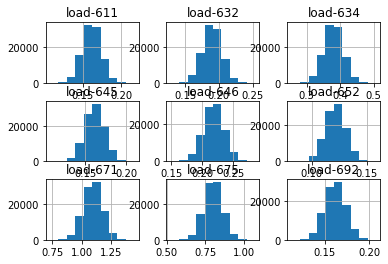

In [6]:
features.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff720ae4210>,
      dtype=object)

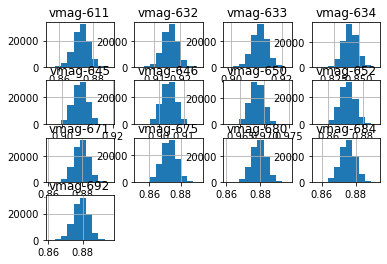

In [7]:
labels.hist()

In [8]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.020046,-0.132160,-0.021454,-0.021495,-0.019223,-0.137006,-0.110304,-0.024238,-0.023217,-0.056572
vmag-646,-0.086474,-0.228395,-0.174776,-0.298769,-0.067853,-0.547298,-0.412960,-0.084970,-0.085142,-0.220738
vmag-645,-0.088140,-0.233107,-0.178247,-0.228672,-0.069011,-0.558910,-0.421875,-0.086483,-0.086819,-0.216807
vmag-632,-0.090864,-0.241835,-0.086768,-0.103492,-0.071260,-0.579590,-0.437670,-0.089086,-0.089764,-0.198925
vmag-633,-0.087539,-0.351729,-0.083343,-0.099481,-0.069388,-0.557443,-0.421417,-0.085484,-0.085808,-0.204626
vmag-634,-0.038337,-0.264779,-0.040705,-0.041729,-0.031290,-0.253145,-0.190968,-0.039854,-0.040087,-0.104544
vmag-611,-0.059673,-0.159657,-0.060138,-0.066237,-0.110490,-0.682213,-0.512931,-0.104191,-0.181470,-0.215222
vmag-684,-0.059961,-0.160856,-0.060472,-0.066622,-0.111234,-0.686586,-0.516017,-0.104635,-0.144018,-0.212267
vmag-671,-0.060145,-0.162090,-0.060937,-0.067011,-0.083057,-0.691941,-0.519826,-0.105176,-0.106685,-0.206319
vmag-692,-0.060137,-0.162069,-0.060930,-0.067001,-0.083047,-0.691848,-0.519997,-0.105211,-0.106673,-0.206324


# Setup Models

In [9]:
import csv
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_validate, train_test_split

# Determine number of samples to get reasonable scores

In [10]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''

regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
regression_model_name = "rf"

linear = LinearRegression()

common_cross_validate_variables = {"cv": 5,
                                   "n_jobs": -1,
                                   "scoring": {"r2": make_scorer(r2_score), 
                                               "rmse": make_scorer(rmse),
                                               "mae": make_scorer(mae),
                                               "maxae": make_scorer(maxae)}}

In [12]:
# cell works, may just be commented out because it is an expensive process and user can just skip to grid search

savefile_descriptor_addon = input("Add on extra descriptor to saved file (ex: -testing_maxae)? ")


for i, n_samples in enumerate([100, 1000, 10000, 100000]):
    current_iteration = i

    n_training_samples = int(n_samples*(80/100))
    X_train, y_train, X_val, y_val = set_data_size(features, labels, n_samples, n_training_samples)

    print("\n\nRun: ", current_iteration)
    print("n_training_samples: ", n_training_samples)
    print("n_validation_samples: ", n_samples-n_training_samples)
    print("n_features: ", X_train.shape[1])
    print("n_labels: ", y_train.shape[1])

    ## regression model to evaluate
    print("\n\n{} REGRESSION\n\n".format(regression_model_name.upper()))
    time_start = time.time()
    regression_model_results = pd.DataFrame(cross_validate(regression_model, 
                                                           X_train, 
                                                           y_train, 
                                                           **common_cross_validate_variables))
    time_regression_model = time.time()
    print("cross validation training time {:.5}".format(time_regression_model-time_start))
    print("cross validation training scores: ")
    regression_model_results.columns = [regression_model_name+"_"+col for col in regression_model_results.columns]
    regression_model_results = add_mean_and_std_rows(regression_model_results)
    display(regression_model_results)

    regression_model.fit(X_train, y_train)
    print("non-cross validation model scores for reference:")
    print("training score: ", r2_score(y_train, regression_model.predict(X_train)))
    print("validation score: ", r2_score(y_val, regression_model.predict(X_val)))
    print("rmse: ", rmse(regression_model.predict(X_val), y_val))



    ## linear regression for baseline comparison
    print("\n\nLINEAR REGRESSION\n\n")
    time_start = time.time()
    linear_results = pd.DataFrame(cross_validate(linear, X_train, y_train, **common_cross_validate_variables))
    time_linear = time.time()
    print("cross validation training time {:.5}".format(time_linear-time_start))
    print("cross validation training scores: ")
    linear_results.columns = ["linear_"+col for col in linear_results.columns]
    linear_results = add_mean_and_std_rows(linear_results)
    display(linear_results)

    linear.fit(X_train, y_train)
    print("non-cross validation model scores for reference:")
    print("training score: ", r2_score(y_train, linear.predict(X_train)))
    print("validation score: ", r2_score(y_val, linear.predict(X_val)))
    print("rmse: ", rmse(linear.predict(X_val), y_val))

        

    ## save models
    datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
    results_to_save = regression_model_results.join(linear_results)
    results_to_save.to_csv(path_to_powerflow_data + 
                           "/results/approximating_with_{}_model_results-{}_samples-gaussian_input-{}{}.csv".format(
                               regression_model_name,
                               n_samples, 
                               datetimestamp,
                               savefile_descriptor_addon))

Add on extra descriptor to saved file (ex: -testing_maxae)? -no_input_preprocessing


Run:  0
n_training_samples:  80
n_validation_samples:  20
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 1.5511
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,0.121119,0.024256,0.483088,0.002660,0.001759,0.011826
1,0.128247,0.025760,0.600844,0.003044,0.002134,0.013764
2,0.123380,0.024803,0.412259,0.002058,0.001577,0.008640
3,0.114624,0.023931,0.369323,0.003622,0.002270,0.022681
4,0.113937,0.023496,0.392132,0.003719,0.002784,0.018082
mean,0.120261,0.024449,0.451529,0.003021,0.002105,0.014999
std,0.006042,0.000874,0.093700,0.000690,0.000471,0.005490


non-cross validation model scores for reference:
training score:  0.935944626433426
validation score:  0.4781036514841169
rmse:  0.0028331047370057996


LINEAR REGRESSION


cross validation training time 0.029402
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.008281,0.001379,0.615345,0.002313,0.001517,0.012137
1,0.006947,0.001129,0.675255,0.002492,0.001674,0.010666
2,0.000707,0.001083,0.457552,0.001929,0.001365,0.007724
3,0.000705,0.001085,0.363265,0.003620,0.002077,0.025616
4,0.000686,0.001030,0.655161,0.002814,0.001976,0.016594
mean,0.003465,0.001142,0.553316,0.002634,0.001722,0.014547
std,0.003816,0.000138,0.136363,0.000637,0.000301,0.006967


non-cross validation model scores for reference:
training score:  0.7006874102126406
validation score:  0.5771666780886703
rmse:  0.0025723391426298223


Run:  1
n_training_samples:  800
n_validation_samples:  200
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 2.0905
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,0.693621,0.042073,0.565301,0.002912,0.002054,0.026803
1,0.713497,0.059317,0.588240,0.002451,0.001785,0.015705
2,0.603055,0.036456,0.604086,0.002623,0.001832,0.020223
3,0.636287,0.057028,0.581922,0.002559,0.001795,0.017739
4,0.613202,0.054163,0.585289,0.002592,0.001751,0.022906
mean,0.651932,0.049807,0.584968,0.002627,0.001844,0.020675
std,0.049148,0.009995,0.013896,0.000172,0.000121,0.004360


non-cross validation model scores for reference:
training score:  0.943914326586029
validation score:  0.6081361443268153
rmse:  0.002717947119188441


LINEAR REGRESSION


cross validation training time 0.071963
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.003504,0.002755,0.676898,0.002547,0.001760,0.026224
1,0.002986,0.002227,0.652348,0.002262,0.001584,0.016341
2,0.002041,0.003372,0.651938,0.002484,0.001683,0.022060
3,0.001138,0.001943,0.647122,0.002336,0.001586,0.016187
4,0.001072,0.001957,0.642123,0.002454,0.001585,0.023243
mean,0.002148,0.002451,0.654086,0.002417,0.001640,0.020811
std,0.001087,0.000611,0.013413,0.000115,0.000080,0.004420


non-cross validation model scores for reference:
training score:  0.6674915217525021
validation score:  0.6876502470724287
rmse:  0.0024225870001674953


Run:  2
n_training_samples:  8000
n_validation_samples:  2000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 26.06
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,8.455497,0.372040,0.615654,0.002584,0.001795,0.024538
1,8.682538,0.361752,0.625918,0.002547,0.001785,0.024799
2,8.241995,0.328748,0.631514,0.002554,0.001789,0.026170
3,8.370659,0.340640,0.606769,0.002566,0.001805,0.022499
4,8.161981,0.316322,0.606019,0.002536,0.001765,0.023677
mean,8.382534,0.343900,0.617175,0.002557,0.001788,0.024336
std,0.202399,0.022974,0.011370,0.000018,0.000015,0.001363


non-cross validation model scores for reference:
training score:  0.9452551206792441
validation score:  0.6288067328003943
rmse:  0.0025509099879578263


LINEAR REGRESSION


cross validation training time 0.10161
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.018971,0.009469,0.652125,0.002470,0.001700,0.023741
1,0.007764,0.013659,0.666757,0.002415,0.001668,0.025300
2,0.005025,0.009049,0.672694,0.002417,0.001663,0.026205
3,0.004812,0.009784,0.646810,0.002443,0.001691,0.021684
4,0.004661,0.009172,0.655039,0.002386,0.001636,0.022525
mean,0.008247,0.010227,0.658685,0.002426,0.001671,0.023891
std,0.006129,0.001940,0.010709,0.000032,0.000025,0.001878


non-cross validation model scores for reference:
training score:  0.6598137007719379
validation score:  0.6683308286380966
rmse:  0.0024318256795411654


Run:  3
n_training_samples:  80000
n_validation_samples:  20000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 378.75
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,121.143495,4.877568,0.638478,0.002520,0.001752,0.026525
1,120.938856,4.981207,0.635507,0.002520,0.001746,0.029580
2,121.428209,4.822083,0.630660,0.002490,0.001735,0.026272
3,120.457680,4.709242,0.638398,0.002502,0.001734,0.024188
4,122.330581,4.935086,0.635455,0.002516,0.001749,0.026476
mean,121.259764,4.865037,0.635700,0.002510,0.001743,0.026608
std,0.695497,0.105684,0.003182,0.000013,0.000008,0.001925


non-cross validation model scores for reference:
training score:  0.9484932247338643
validation score:  0.636775088068054
rmse:  0.00250913839076402


LINEAR REGRESSION


cross validation training time 0.96597
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.217829,0.165992,0.666148,0.002429,0.001671,0.028248
1,0.165349,0.152520,0.660470,0.002441,0.001680,0.028361
2,0.076194,0.142294,0.656742,0.002407,0.001668,0.025590
3,0.090317,0.165237,0.664634,0.002418,0.001663,0.024641
4,0.086697,0.186167,0.662581,0.002431,0.001673,0.025395
mean,0.127277,0.162442,0.662115,0.002425,0.001671,0.026447
std,0.061789,0.016490,0.003688,0.000013,0.000006,0.001733


non-cross validation model scores for reference:
training score:  0.6623151816181319
validation score:  0.6637186851920581
rmse:  0.0024232301711452076


# Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

In [17]:
n_samples = 100000
if n_samples < 100000:
    raise ValueError("So you don't accidentally run this on 100 samples again")

n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)
# remove bad label
y_train = y_train.T[1:].T
y_val = y_val.T[1:].T

In [18]:
rf = RandomForestRegressor()
params = {"n_estimators": range(100), 
          "max_depth": [None]+[i for i in range(1, 100)]}
grid = RandomizedSearchCV(rf, params, cv=3, n_iter=10, n_jobs=-1, refit=False,
                          scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse), "mae": make_scorer(mae)}, 
                          iid=False, verbose=10)

grid.fit(X_train, y_train)

print("\n\nRF\n\n")
grid_results = pd.DataFrame(grid.cv_results_)
display(grid_results.sort_values(by=["rank_test_r2"]))
datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
filepath = (path_to_powerflow_data + 
            "/results/approximating_with_rf_grid_results-{}_samples-{}.csv".format(n_samples, datetimestamp))
print("Saving to ", filepath)
grid_results.to_csv(filepath)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.8min




RF




[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,66.531391,0.622077,2.545954,0.086762,80,29,"{'n_estimators': 80, 'max_depth': 29}",0.921858,0.922751,0.922099,0.922236,0.000377,1,0.002894,0.002883,0.002889,0.002889,0.000004,10
5,59.921115,0.734938,2.203448,0.029155,72,98,"{'n_estimators': 72, 'max_depth': 98}",0.921811,0.921741,0.921164,0.921572,0.000290,2,0.002894,0.002901,0.002907,0.002901,0.000005,9
7,52.694661,0.098162,2.040517,0.075283,64,33,"{'n_estimators': 64, 'max_depth': 33}",0.921495,0.921932,0.921088,0.921505,0.000345,3,0.002899,0.002897,0.002909,0.002902,0.000005,8
9,42.708556,0.272464,1.667782,0.055191,52,71,"{'n_estimators': 52, 'max_depth': 71}",0.920678,0.921160,0.921027,0.920955,0.000203,4,0.002914,0.002911,0.002911,0.002912,0.000001,7
6,49.611883,0.197651,1.920520,0.055440,60,93,"{'n_estimators': 60, 'max_depth': 93}",0.920492,0.921506,0.920086,0.920695,0.000597,5,0.002919,0.002905,0.002928,0.002917,0.000009,6
4,32.702112,0.183965,1.336063,0.059603,40,74,"{'n_estimators': 40, 'max_depth': 74}",0.918704,0.919897,0.919109,0.919237,0.000495,6,0.002951,0.002934,0.002942,0.002942,0.000007,5
1,20.698034,0.078871,0.903889,0.030214,25,73,"{'n_estimators': 25, 'max_depth': 73}",0.915674,0.917252,0.916619,0.916515,0.000648,7,0.003008,0.002984,0.002990,0.002994,0.000010,4
2,19.139486,0.097723,0.843532,0.018133,23,66,"{'n_estimators': 23, 'max_depth': 66}",0.915774,0.915434,0.915281,0.915496,0.000206,8,0.003007,0.003020,0.003011,0.003013,0.000005,3
3,8.422979,0.240346,0.468810,0.022842,10,48,"{'n_estimators': 10, 'max_depth': 48}",0.903202,0.904700,0.903273,0.903725,0.000690,9,0.003218,0.003203,0.003221,0.003214,0.000008,2
8,6.304425,0.014633,0.322273,0.010596,23,4,"{'n_estimators': 23, 'max_depth': 4}",0.475762,0.463664,0.459374,0.466267,0.006939,10,0.007396,0.007507,0.007516,0.007473,0.000054,1


Saving to  ../../pypsa/examples/ieee-13//ieee-13-with-load-gen-uniform-data-100000-samples//results/approximating_with_rf_grid_results-100000_samples-2019-09-13-07-25.csv


In [19]:
# for reading values if you closed the notebook
imported_results = pd.read_csv(filepath)
display(imported_results.sort_values(by=["rank_test_r2"]))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,0,66.531391,0.622077,2.545954,0.086762,80,29,"{'n_estimators': 80, 'max_depth': 29}",0.921858,0.922751,0.922099,0.922236,0.000377,1,0.002894,0.002883,0.002889,0.002889,0.000004,10
5,5,59.921115,0.734938,2.203448,0.029155,72,98,"{'n_estimators': 72, 'max_depth': 98}",0.921811,0.921741,0.921164,0.921572,0.000290,2,0.002894,0.002901,0.002907,0.002901,0.000005,9
7,7,52.694661,0.098162,2.040517,0.075283,64,33,"{'n_estimators': 64, 'max_depth': 33}",0.921495,0.921932,0.921088,0.921505,0.000345,3,0.002899,0.002897,0.002909,0.002902,0.000005,8
9,9,42.708556,0.272464,1.667782,0.055191,52,71,"{'n_estimators': 52, 'max_depth': 71}",0.920678,0.921160,0.921027,0.920955,0.000203,4,0.002914,0.002911,0.002911,0.002912,0.000001,7
6,6,49.611883,0.197651,1.920520,0.055440,60,93,"{'n_estimators': 60, 'max_depth': 93}",0.920492,0.921506,0.920086,0.920695,0.000597,5,0.002919,0.002905,0.002928,0.002917,0.000009,6
4,4,32.702112,0.183965,1.336063,0.059603,40,74,"{'n_estimators': 40, 'max_depth': 74}",0.918704,0.919897,0.919109,0.919237,0.000495,6,0.002951,0.002934,0.002942,0.002942,0.000007,5
1,1,20.698034,0.078871,0.903889,0.030214,25,73,"{'n_estimators': 25, 'max_depth': 73}",0.915674,0.917252,0.916619,0.916515,0.000648,7,0.003008,0.002984,0.002990,0.002994,0.000010,4
2,2,19.139486,0.097723,0.843532,0.018133,23,66,"{'n_estimators': 23, 'max_depth': 66}",0.915774,0.915434,0.915281,0.915496,0.000206,8,0.003007,0.003020,0.003011,0.003013,0.000005,3
3,3,8.422979,0.240346,0.468810,0.022842,10,48,"{'n_estimators': 10, 'max_depth': 48}",0.903202,0.904700,0.903273,0.903725,0.000690,9,0.003218,0.003203,0.003221,0.003214,0.000008,2
8,8,6.304425,0.014633,0.322273,0.010596,23,4,"{'n_estimators': 23, 'max_depth': 4}",0.475762,0.463664,0.459374,0.466267,0.006939,10,0.007396,0.007507,0.007516,0.007473,0.000054,1
